### Edgar Moises Hernandez-Gonzalez
#### 26/02/20
#### Clasificacion de imagenes motoras en EEG con ConvLSTM2D
##### Caracteristicas = RAW
##### 2 canales C3 y C4
##### 5 ejecuciones independientes

##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 7000:8000]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 11000:12000]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 7000:8000]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 11000:12000]

In [ ]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
x_train = np.concatenate((c3_train, c4_train), axis=1)
x_test = np.concatenate((c3_test, c4_test), axis=1)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 2000)
(288, 2000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#escalar los datos para que tengan media = 0 y desviacion estandar = 1
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#convertir de 2D a 5D
x_train = x_train.reshape((n_samples_train, 1, 1, 2, 1000))
x_test = x_test.reshape((n_samples_test, 1, 1, 2, 1000))

print(x_train.shape)
print(x_test.shape)

(288, 1, 1, 2, 1000)
(288, 1, 1, 2, 1000)


In [ ]:
x_train = np.transpose(x_train, (0,1,2,4,3))
x_test = np.transpose(x_test, (0,1,2,4,3))

print(x_train.shape)
print(x_test.shape)

(288, 1, 1, 1000, 2)
(288, 1, 1, 1000, 2)


In [ ]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(256, (1,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-3)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Iteration: 1
288/288 - 0s - loss: 8.0053 - acc: 0.4062
kappa:  0.20833333333333337
f1: 0.3976904425034743
confusion matrix:
 [[41 11 10 10]
 [41 20  4  7]
 [15  2 21 34]
 [14  5 18 35]]


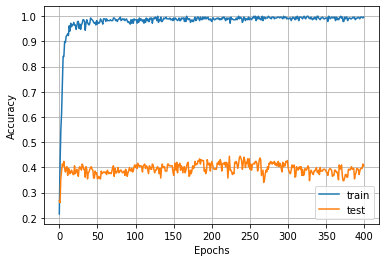

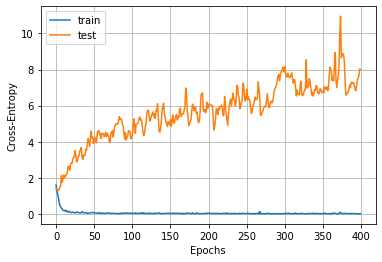

Iteration: 2
288/288 - 0s - loss: 6.5529 - acc: 0.4410
kappa:  0.25462962962962965
f1: 0.4342852641765628
confusion matrix:
 [[27 29  7  9]
 [29 29  4 10]
 [ 5  4 25 38]
 [ 4  5 17 46]]


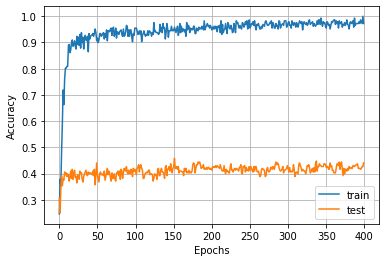

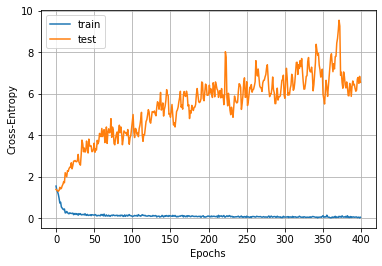


Resultados:
loss: [8.005326959821913, 6.552900049421522]
accuracy: [0.40625, 0.4409722]
kappa: [0.20833333333333337, 0.25462962962962965]
f1: [0.3976904425034743, 0.4342852641765628]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
array_f1 = []
for i in range(2):
    print("Iteration:", i+1);
    
    model = Conv_LSTM_2D()

    history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                        validation_data=(x_test, y_test), verbose=0)
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    array_loss.append(test_loss)
    array_acc.append(test_acc)
    
    probabilidades = model.predict(x_test)
    y_pred = np.argmax(probabilidades, 1) #1=fila
    
    kappa = cohen_kappa_score(y_test, y_pred)
    array_kappa.append(kappa)
    print("kappa: ", kappa)

    f1 = f1_score(y_test, y_pred, average='macro')
    array_f1.append(f1)
    print("f1:", f1)
    
    matriz_confusion = confusion_matrix(y_test, y_pred)
    print("confusion matrix:\n", matriz_confusion)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend(['train', 'test'])
    plt.show()
    
print()    
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
print("f1:", array_f1)

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_25 (ConvLSTM2D) (None, 1, 1000, 256)      793600    
_________________________________________________________________
dropout_46 (Dropout)         (None, 1, 1000, 256)      0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 256000)            0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                16384064  
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 260       
Total params: 17,177,924
Trainable params: 17,177,924
Non-trainable params: 0
_________________________________________

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("Mean F1: %.4f" % np.mean(array_f1))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Max F1: %.4f" % np.max(array_f1))

Mean Accuracy: 0.4236
Mean Kappa: 0.2315
Mean F1: 0.4160
Max Accuracy: 0.4410
Max Kappa: 0.2546
Max F1: 0.4343
